# Paper Metrics & Plots from Saved Predictions (.npz)

This notebook generates common scientific metrics and figures from exported prediction files produced by your evaluation pipeline.

**Inputs (expected in `eval_dir`)**:
- `internal_preds_ensemble.npz` or `internal_preds_fold_*.npz`
- `external_preds_ensemble.npz` or `external_preds_fold_*.npz`

Each `.npz` should contain:
- `y_true` (0/1)
- `y_prob` (probability of class 1 = **lung**)

**Outputs (written to `out_dir`)**:
- Confusion matrix PNG
- ROC curve PNG
- PR curve PNG
- Calibration curve PNG
- `*_paper_metrics.json`
- `*_predictions.csv` with `lung/non_lung` labels
- `*_curves.npz` with curve points


In [1]:
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import sys

# Class name mapping (0/1 -> string labels)
CLASS_NAMES = {0: "non_lung", 1: "lung"}


In [2]:
def load_npz(npz_path: Path):
    d = np.load(npz_path)
    y_true = d["y_true"].astype(int).reshape(-1)
    y_prob = d["y_prob"].astype(float).reshape(-1)
    return y_true, y_prob


def confusion_from_threshold(y_true, y_prob, thr=0.5):
    y_pred = (y_prob >= thr).astype(int)
    tp = int(np.sum((y_true == 1) & (y_pred == 1)))
    tn = int(np.sum((y_true == 0) & (y_pred == 0)))
    fp = int(np.sum((y_true == 0) & (y_pred == 1)))
    fn = int(np.sum((y_true == 1) & (y_pred == 0)))
    return tp, tn, fp, fn


def basic_metrics(y_true, y_prob, thr=0.5):
    tp, tn, fp, fn = confusion_from_threshold(y_true, y_prob, thr)
    n = tp + tn + fp + fn

    acc = (tp + tn) / max(n, 1)
    sens = tp / max(tp + fn, 1)  # recall, TPR
    spec = tn / max(tn + fp, 1)  # TNR
    prec = tp / max(tp + fp, 1)
    f1 = (2 * prec * sens) / max(prec + sens, 1e-12)
    bal_acc = 0.5 * (sens + spec)

    # Matthews correlation coefficient (MCC)
    denom = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    mcc = ((tp * tn) - (fp * fn)) / denom if denom > 0 else 0.0

    return {
        "n": int(n),
        "threshold": float(thr),
        "tp": tp, "tn": tn, "fp": fp, "fn": fn,
        "accuracy": float(acc),
        "balanced_accuracy": float(bal_acc),
        "sensitivity_recall": float(sens),
        "specificity": float(spec),
        "precision": float(prec),
        "f1": float(f1),
        "mcc": float(mcc),
    }


def roc_curve_manual(y_true, y_prob, num=500):
    thresholds = np.linspace(1.0, 0.0, num=num)
    tpr = np.zeros_like(thresholds)
    fpr = np.zeros_like(thresholds)

    P = np.sum(y_true == 1)
    N = np.sum(y_true == 0)

    for i, thr in enumerate(thresholds):
        tp, tn, fp, fn = confusion_from_threshold(y_true, y_prob, thr)
        tpr[i] = tp / max(P, 1)
        fpr[i] = fp / max(N, 1)

    order = np.argsort(fpr)
    fpr_s = fpr[order]
    tpr_s = tpr[order]
    auc = float(np.trapezoid(tpr_s, fpr_s))
    return fpr_s, tpr_s, thresholds, auc


def pr_curve_manual(y_true, y_prob, num=500):
    thresholds = np.linspace(1.0, 0.0, num=num)
    precision = np.zeros_like(thresholds)
    recall = np.zeros_like(thresholds)

    P = np.sum(y_true == 1)

    for i, thr in enumerate(thresholds):
        tp, tn, fp, fn = confusion_from_threshold(y_true, y_prob, thr)
        precision[i] = tp / max(tp + fp, 1)
        recall[i] = tp / max(P, 1)

    order = np.argsort(recall)
    r = recall[order]
    p = precision[order]
    ap = float(np.trapezoid(p, r))
    return r, p, thresholds, ap


def brier_score(y_true, y_prob):
    return float(np.mean((y_prob - y_true) ** 2))


def calibration_curve(y_true, y_prob, n_bins=10):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    bin_ids = np.digitize(y_prob, bins) - 1
    bin_ids = np.clip(bin_ids, 0, n_bins - 1)

    frac_pos = []
    mean_pred = []
    counts = []

    for b in range(n_bins):
        mask = bin_ids == b
        if np.sum(mask) == 0:
            continue
        counts.append(int(np.sum(mask)))
        frac_pos.append(float(np.mean(y_true[mask])))
        mean_pred.append(float(np.mean(y_prob[mask])))

    return np.array(mean_pred), np.array(frac_pos), np.array(counts)


In [3]:
def save_confusion_matrix_plot(tp, tn, fp, fn, out_png: Path, title: str):
    cm = np.array([[tn, fp],
                   [fn, tp]], dtype=int)

    fig = plt.figure(figsize=(4.8, 4.2))
    ax = plt.gca()
    ax.imshow(cm)

    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Pred non_lung", "Pred lung"])
    ax.set_yticklabels(["True non_lung", "True lung"])
    ax.set_title(title)

    for (i, j), v in np.ndenumerate(cm):
        ax.text(j, i, str(v), ha="center", va="center")

    plt.tight_layout()
    fig.savefig(out_png, dpi=300)
    plt.close(fig)


def save_roc_plot(fpr, tpr, auc, out_png: Path, title: str):
    fig = plt.figure(figsize=(5.2, 4.2))
    ax = plt.gca()
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"{title} (AUC={auc:.3f})")
    plt.tight_layout()
    fig.savefig(out_png, dpi=300)
    plt.close(fig)


def save_pr_plot(recall, precision, ap, out_png: Path, title: str):
    fig = plt.figure(figsize=(5.2, 4.2))
    ax = plt.gca()
    ax.plot(recall, precision)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(f"{title} (AP={ap:.3f})")
    plt.tight_layout()
    fig.savefig(out_png, dpi=300)
    plt.close(fig)


def save_calibration_plot(mean_pred, frac_pos, out_png: Path, title: str):
    fig = plt.figure(figsize=(5.2, 4.2))
    ax = plt.gca()
    ax.plot(mean_pred, frac_pos, marker="o")
    ax.plot([0, 1], [0, 1])
    ax.set_xlabel("Mean predicted probability")
    ax.set_ylabel("Fraction of positives")
    ax.set_title(title)
    plt.tight_layout()
    fig.savefig(out_png, dpi=300)
    plt.close(fig)


In [4]:
def load_split_predictions(eval_dir: Path, split: str, use: str = "ensemble"):
    if use == "ensemble":
        npz = eval_dir / f"{split}_preds_ensemble.npz"
        y_true, y_prob = load_npz(npz)
        label = f"{split} ensemble"
    else:
        files = sorted(eval_dir.glob(f"{split}_preds_fold_*.npz"))
        if not files:
            raise FileNotFoundError(f"No fold files found for {split} in {eval_dir}")
        probs = []
        y_true = None
        for f in files:
            yt, yp = load_npz(f)
            if y_true is None:
                y_true = yt
            probs.append(yp)
        y_prob = np.mean(np.stack(probs, axis=0), axis=0)
        label = f"{split} mean-over-folds"
    return y_true, y_prob, label

## Runs

In [5]:
path_to_evals = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/Evaluations/eval_internal_external_patient_level_23_02_26")

runs = [f for f in path_to_evals.iterdir() if f.is_dir() and f.name.startswith("lung_vs_nolung")]
runs_dict = {
    r.name.removeprefix("lung_vs_nolung_2cls_"): r
    for r in runs
}

print("Found runs:")
runs_dict

Found runs:


{'t1c_fine_resnet152_22_02_2026': PosixPath('/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/Evaluations/eval_internal_external_patient_level_23_02_26/lung_vs_nolung_2cls_t1c_fine_resnet152_22_02_2026'),
 't1c_scratch_resnet34_22_02_2026': PosixPath('/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/Evaluations/eval_internal_external_patient_level_23_02_26/lung_vs_nolung_2cls_t1c_scratch_resnet34_22_02_2026'),
 't1c_scratch_inceptionv3_22_02_2026': PosixPath('/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/Evaluations/eval_internal_external_patient_level_23_02_26/lung_vs_nolung_2cls_t1c_scratch_inceptionv3_22_02_2026'),
 'maxinfo_scratch_resnext101_23_02_2026': PosixPath('/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/Evaluations/eval_internal_external_patient_level_23_02_26/lung_vs_nolung_2cls_maxinfo_scratch_resnext101_23_02_2026'),
 't1c_rough_resnext50_22_02_2026': PosixPath('/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/Evaluations/eval_internal_external_patient_le

In [6]:
OUT_ROOT = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/Metrics")

use = "ensemble"
threshold = 0.5

In [32]:
import re
import json
from pathlib import Path
import pandas as pd
import numpy as np

# Where the evaluation run folders live (your existing path)
path_to_evals = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Training/Evaluations/eval_internal_external_patient_level_23_02_26")

runs = [f for f in path_to_evals.iterdir() if f.is_dir() and f.name.startswith("lung_vs_nolung")]
runs_dict = {r.name.removeprefix("lung_vs_nolung_2cls_"): r for r in runs}

def parse_strategy(run: str):
    r = run.lower()
    # robust: look for whole tokens to avoid accidental matches
    # your runs contain "..._scratch_..." / "..._rough_..." / "..._fine_..."
    if re.search(r"(^|_)scratch(_|$)", r):
        return "scratch"
    if re.search(r"(^|_)rough(_|$)", r):
        return "rough"
    if re.search(r"(^|_)fine(_|$)", r):
        return "fine"
    return None

def apply_label_map(labels, label_map=None):
    """
    label_map example:
      {"t1c": "T1CE", "4 seq": "4 sequences", "clinical": "+clinical", "max_info": "max input"}
      {"scratch": "Scratch", "rough": "Rough pretraining", "fine": "Fine pretraining"}
    """
    if label_map is None:
        return [str(x) for x in labels]
    return [label_map.get(str(x), str(x)) for x in labels]

def parse_arch(run: str):
    r = run.lower()
    if "resnext101" in r:
        return "ResNeXt101"
    if "resnext50" in r:
        return "ResNeXt50"
    if "resnet152" in r:
        return "ResNet152"
    return None

def parse_input_variant(run: str):
    r = run.lower()

    if r.startswith("4seq"):
        return "4 seq"
    if r.startswith("t1c_clin"):
        return "clinical"
    if r.startswith("maxinfo"):
        return "max_info"
    if r.startswith("t1c"):
        return "t1c"

    return None

def format_auc_ci(val, lo, hi, decimals=3):
    if pd.isna(val):
        return ""
    if pd.isna(lo) or pd.isna(hi):
        return f"{val:.{decimals}f}"
    return f"{val:.{decimals}f} [{lo:.{decimals}f}, {hi:.{decimals}f}]"

# metrics you want to plot (these exist in your JSON example)
metrics = ["auc", "accuracy", "f1", "sensitivity", "specificity", "mcc"]

rows = []

for run, run_path in runs_dict.items():
    arch = parse_arch(run)
    if arch not in ["ResNeXt50", "ResNeXt101", "ResNet152"]:
        continue

    variant = parse_input_variant(run)
    if variant is None:
        continue

    for split in ["internal", "external"]:
        json_path = run_path / f"{split}_ensemble.json"
        if not json_path.exists():
            continue

        met = json.loads(json_path.read_text())

        rows.append({
            "run": run,
            "arch": arch,
            "variant": variant,
            "split": split,
            "auc": met.get("auc"),
            "auc_ci_low": met.get("auc_ci_low"),
            "auc_ci_high": met.get("auc_ci_high"),
        })

df_ci = pd.DataFrame(rows)

df_ci = df_ci.copy()
df_ci["strategy"] = df_ci["run"].apply(parse_strategy)

# quick check
df_ci[["run","arch","variant","strategy","split","auc"]].head(10)

df_ci.head()

,run,arch,variant,split,auc,auc_ci_low,auc_ci_high,strategy
0,t1c_fine_resnet152_22_02_2026,ResNet152,t1c,internal,0.439423,0.280134,0.618100,fine
1,t1c_fine_resnet152_22_02_2026,ResNet152,t1c,external,0.510266,0.418442,0.597810,fine
2,maxinfo_scratch_resnext101_23_02_2026,ResNeXt101,max_info,internal,0.636538,0.455207,0.805772,scratch
3,maxinfo_scratch_resnext101_23_02_2026,ResNeXt101,max_info,external,0.531124,0.445189,0.614525,scratch
4,t1c_rough_resnext50_22_02_2026,ResNeXt50,t1c,internal,0.503846,0.335200,0.673508,rough


Export as .csv file

In [ ]:
df_ci.to_csv(OUT_ROOT / "summary_metrics.csv", index=False)

# Input variations plots

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

variant_order = ["t1c", "4 seq", "clinical", "max_info"]

variant_label_map = {
    "t1c": "T1CE",
    "4 seq": "4 sequences",
    "clinical": "+ clinical",
    "max_info": "Max input",
}

def plot_architecture(df_ci, arch):
    d = df_ci[df_ci["arch"] == arch].copy()
    if d.empty:
        print(f"No data for {arch}")
        return

    d["variant"] = pd.Categorical(d["variant"],
                                  categories=variant_order,
                                  ordered=True)

    pv = d.pivot_table(index="variant", columns="split", values="auc", observed=False)
    plo = d.pivot_table(index="variant", columns="split", values="auc_ci_low", observed=False)
    phi = d.pivot_table(index="variant", columns="split", values="auc_ci_high", observed=False)

    pv = pv.dropna(how="all")
    plo = plo.reindex(pv.index)
    phi = phi.reindex(pv.index)

    x = np.arange(len(pv.index))
    width = 0.38

    plt.figure(figsize=(8, 4.8))
    ax = plt.gca()

    for split, offset, label in [
        ("internal", -width/2, "Internal test"),
        ("external", +width/2, "External validation")
    ]:
        vals = pv.get(split, pd.Series(index=pv.index, data=np.nan)).values.astype(float)
        lo = plo.get(split, pd.Series(index=pv.index, data=np.nan)).values.astype(float)
        hi = phi.get(split, pd.Series(index=pv.index, data=np.nan)).values.astype(float)

        lower_err = np.where(np.isfinite(lo), vals - lo, 0.0)
        upper_err = np.where(np.isfinite(hi), hi - vals, 0.0)
        yerr = np.vstack([lower_err, upper_err])

        ax.bar(x + offset, vals, width, label=label,
               yerr=yerr, capsize=4)

    ax.set_xticks(x)
    ax.set_xticklabels(apply_label_map([str(v) for v in pv.index], variant_label_map))
    ax.set_ylim(0.0, 1.0)
    ax.set_ylabel("AUC")
    ax.set_title(f"{arch}: Impact of Input Variation (95% CI)")
    ax.legend()

    ax.axhline(0.5, linestyle="--", linewidth=1)

    plt.tight_layout()
    plt.show()

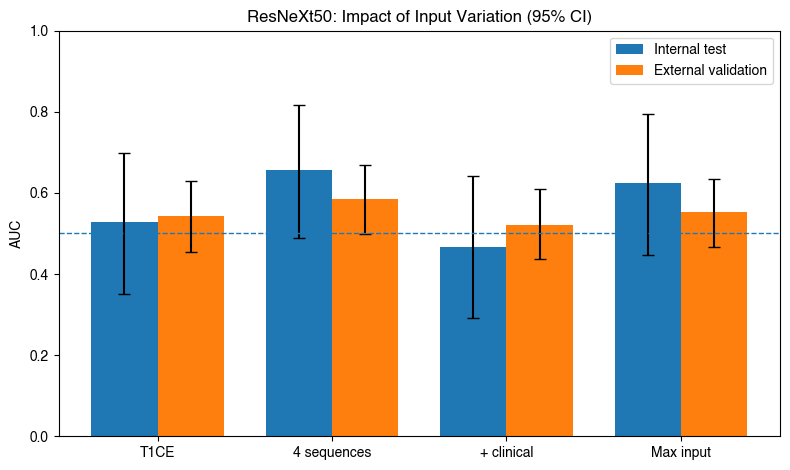

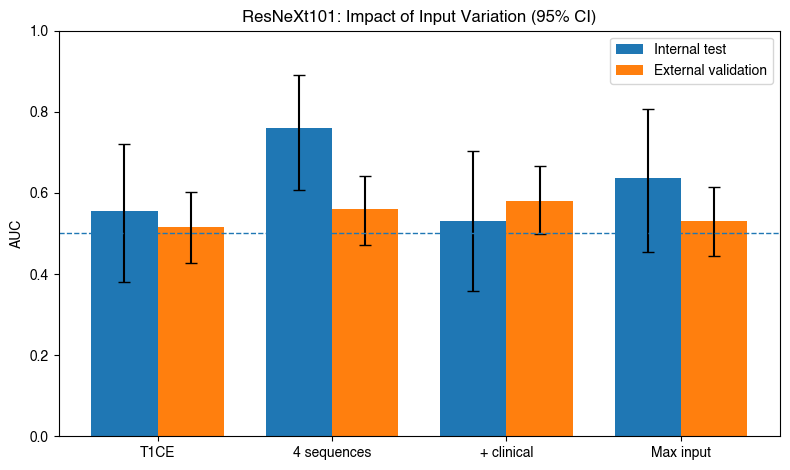

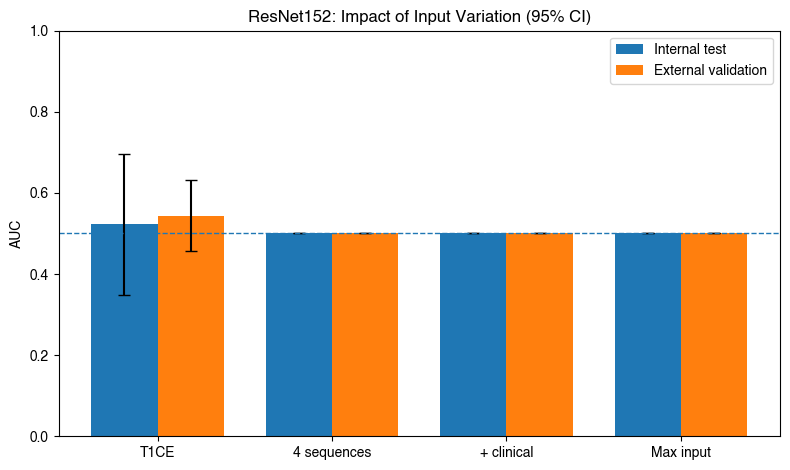

In [30]:
for arch in ["ResNeXt50", "ResNeXt101", "ResNet152"]:
    plot_architecture(df_ci, arch)

In [34]:
def plot_input_variations_with_table(df_ci, arch, x_label_map=None, decimals=3):
    d = df_ci[(df_ci["arch"] == arch)].copy()
    d = d.dropna(subset=["auc"])

    d["variant"] = pd.Categorical(d["variant"], categories=variant_order, ordered=True)

    pv = d.pivot_table(index="variant", columns="split", values="auc", aggfunc="mean")
    plo = d.pivot_table(index="variant", columns="split", values="auc_ci_low", aggfunc="mean")
    phi = d.pivot_table(index="variant", columns="split", values="auc_ci_high", aggfunc="mean")

    pv = pv.dropna(how="all")
    plo = plo.reindex(pv.index)
    phi = phi.reindex(pv.index)

    # --------- PLOT ----------
    x = np.arange(len(pv.index))
    width = 0.38
    plt.figure(figsize=(8, 4.8))
    ax = plt.gca()

    for split, offset, label in [("internal", -width/2, "Internal test"),
                                 ("external", +width/2, "External validation")]:
        vals = pv.get(split, pd.Series(index=pv.index, data=np.nan)).astype(float).values
        lo = plo.get(split, pd.Series(index=pv.index, data=np.nan)).astype(float).values
        hi = phi.get(split, pd.Series(index=pv.index, data=np.nan)).astype(float).values

        lower_err = np.where(np.isfinite(lo), vals - lo, 0.0)
        upper_err = np.where(np.isfinite(hi), hi - vals, 0.0)
        yerr = np.vstack([lower_err, upper_err])

        ax.bar(x + offset, vals, width, label=label, yerr=yerr, capsize=4)

    ax.axhline(0.5, linestyle="--", linewidth=1)

    xticklabels = [str(v) for v in pv.index]
    if x_label_map is not None:
        xticklabels = [x_label_map.get(lbl, lbl) for lbl in xticklabels]

    ax.set_xticks(x)
    ax.set_xticklabels(xticklabels)
    ax.set_ylim(0.0, 1.0)
    ax.set_ylabel("AUC")
    ax.set_title(f"{arch}: Impact of Input Variation (95% CI)")
    ax.legend()

    plt.tight_layout()
    plt.show()

    # --------- TABLE (exact values) ----------
    # Build a nice "AUC [CI]" view
    table_rows = []
    for v in pv.index:
        row = {"variant": str(v)}
        for split in ["internal", "external"]:
            val = pv.loc[v, split] if split in pv.columns else np.nan
            lo = plo.loc[v, split] if split in plo.columns else np.nan
            hi = phi.loc[v, split] if split in phi.columns else np.nan
            row[f"{split}_auc_ci"] = format_auc_ci(val, lo, hi, decimals=decimals)
            row[f"{split}_auc"] = float(val) if pd.notna(val) else np.nan
            row[f"{split}_auc_ci_low"] = float(lo) if pd.notna(lo) else np.nan
            row[f"{split}_auc_ci_high"] = float(hi) if pd.notna(hi) else np.nan
        table_rows.append(row)

    df_table = pd.DataFrame(table_rows)

    # Apply label mapping to the first column as well, for copy/paste into paper text
    if x_label_map is not None:
        df_table["variant"] = df_table["variant"].map(lambda s: x_label_map.get(s, s))

    display(df_table)
    return df_table

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

variant_order = ["t1c", "4 seq", "clinical", "max_info"]
arch_order = ["ResNeXt50", "ResNeXt101", "ResNet152"]

def _prep_arch_df(df_ci: pd.DataFrame, arch: str):
    """Return pivot tables (value, ci_low, ci_high) for one architecture in fixed x-order."""
    d = df_ci[df_ci["arch"] == arch].copy()
    if d.empty:
        return None, None, None

    d["variant"] = pd.Categorical(d["variant"], categories=variant_order, ordered=True)

    pv  = d.pivot_table(index="variant", columns="split", values="auc", aggfunc="mean", observed=False)
    plo = d.pivot_table(index="variant", columns="split", values="auc_ci_low", aggfunc="mean", observed=False)
    phi = d.pivot_table(index="variant", columns="split", values="auc_ci_high", aggfunc="mean", observed=False)

    # keep only variants that exist for that model
    pv = pv.dropna(how="all")
    plo = plo.reindex(pv.index)
    phi = phi.reindex(pv.index)

    return pv, plo, phi

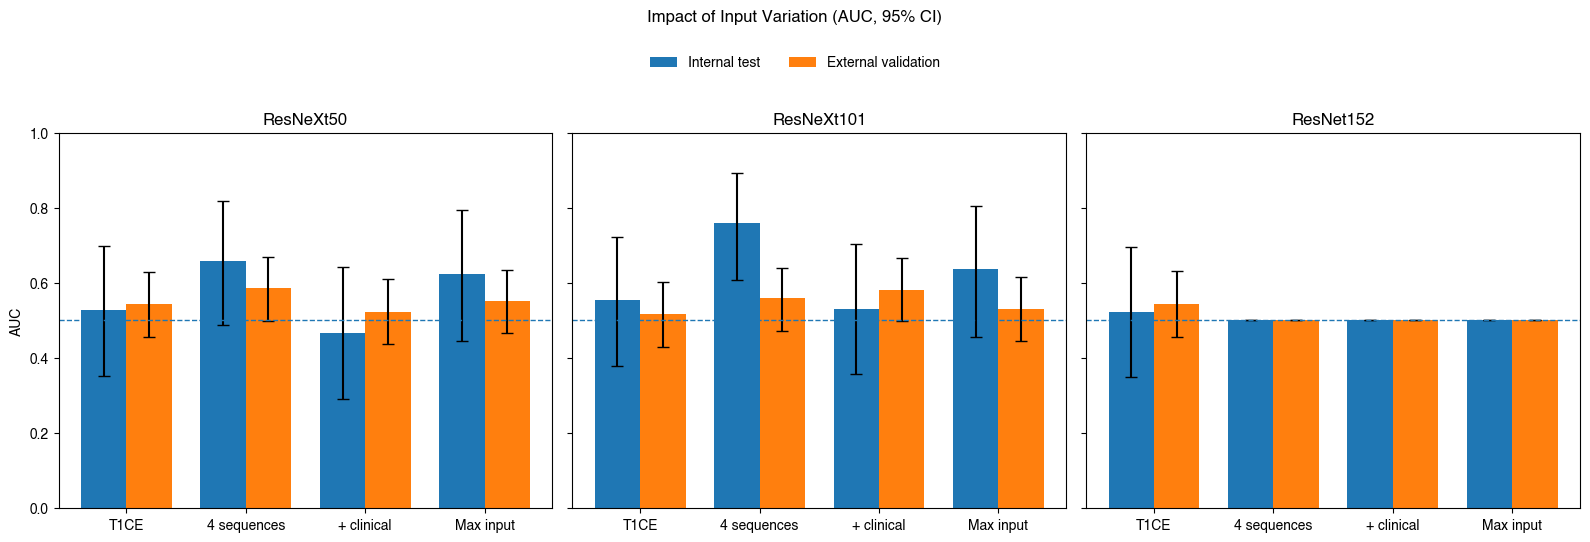

In [31]:
def plot_3panel_grouped_bars(df_ci: pd.DataFrame, suptitle: str = "Impact of Input Variation (AUC, 95% CI)"):
    fig, axes = plt.subplots(1, 3, figsize=(16, 4.8), sharey=True)

    width = 0.38

    for ax, arch in zip(axes, arch_order):
        pv, plo, phi = _prep_arch_df(df_ci, arch)
        if pv is None:
            ax.set_title(f"{arch}\n(no data)")
            ax.axis("off")
            continue

        x = np.arange(len(pv.index))

        for split, offset, label in [
            ("internal", -width/2, "Internal test"),
            ("external", +width/2, "External validation")
        ]:
            vals = pv.get(split, pd.Series(index=pv.index, data=np.nan)).astype(float).values
            lo   = plo.get(split, pd.Series(index=pv.index, data=np.nan)).astype(float).values
            hi   = phi.get(split, pd.Series(index=pv.index, data=np.nan)).astype(float).values

            lower_err = np.where(np.isfinite(lo), vals - lo, 0.0)
            upper_err = np.where(np.isfinite(hi), hi - vals, 0.0)
            yerr = np.vstack([lower_err, upper_err])

            ax.bar(x + offset, vals, width, label=label, yerr=yerr, capsize=4)

        # chance reference
        ax.axhline(0.5, linestyle="--", linewidth=1)

        ax.set_title(arch)
        ax.set_xticks(x)
        ax.set_xticklabels(apply_label_map([str(v) for v in pv.index], variant_label_map))
        ax.set_ylim(0.0, 1.0)
        ax.grid(False)

    axes[0].set_ylabel("AUC")

    # single shared legend (avoid repeating in each panel)
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=2, frameon=False, bbox_to_anchor=(0.5, 1.05))

    fig.suptitle(suptitle, y=1.12)
    plt.tight_layout()
    plt.rcParams['font.family'] = 'Helvetica'
    plt.show()

plot_3panel_grouped_bars(df_ci)

## Pretraining variations plots

In [26]:
def plot_pretraining_strategies(df_ci: pd.DataFrame,
                                arch: str,
                                metric: str = "auc",
                                strategy_order=("scratch", "rough", "fine"),
                                x_label_map=None,
                                title=None):
    """
    One plot per architecture:
      x-axis: pretraining strategies
      two bars per strategy: internal vs external
      y-axis: AUC
      error bars: 95% CI if available (auc_ci_low/high)
    """

    d = df_ci[(df_ci["arch"] == arch)].copy()
    d = d.dropna(subset=[metric])
    d = d[d["strategy"].isin(strategy_order)].copy()

    if d.empty:
        print(f"[WARN] No strategy data for {arch}")
        return

    # enforce order
    d["strategy"] = pd.Categorical(d["strategy"], categories=list(strategy_order), ordered=True)

    pv = d.pivot_table(index="strategy", columns="split", values=metric, aggfunc="mean", observed=False)
    plo = d.pivot_table(index="strategy", columns="split", values=f"{metric}_ci_low", aggfunc="mean", observed=False)
    phi = d.pivot_table(index="strategy", columns="split", values=f"{metric}_ci_high", aggfunc="mean", observed=False)

    pv = pv.dropna(how="all")
    plo = plo.reindex(pv.index)
    phi = phi.reindex(pv.index)

    x = np.arange(len(pv.index))
    width = 0.38

    plt.figure(figsize=(7.2, 4.8))
    ax = plt.gca()

    for split, offset, label in [
        ("internal", -width/2, "Internal test"),
        ("external", +width/2, "External validation")
    ]:
        vals = pv.get(split, pd.Series(index=pv.index, data=np.nan)).astype(float).values
        lo = plo.get(split, pd.Series(index=pv.index, data=np.nan)).astype(float).values
        hi = phi.get(split, pd.Series(index=pv.index, data=np.nan)).astype(float).values

        lower_err = np.where(np.isfinite(lo), vals - lo, 0.0)
        upper_err = np.where(np.isfinite(hi), hi - vals, 0.0)
        yerr = np.vstack([lower_err, upper_err])

        ax.bar(x + offset, vals, width, label=label, yerr=yerr, capsize=4)

    # chance-level line
    ax.axhline(0.5, linestyle="--", linewidth=1)

    # label mapping support
    xticklabels = apply_label_map([str(s) for s in pv.index], x_label_map)

    ax.set_xticks(x)
    ax.set_xticklabels(xticklabels)
    ax.set_ylim(0.0, 1.0)
    ax.set_ylabel("AUC")

    if title is None:
        title = f"{arch}: Pretraining strategy comparison (95% CI)"
    ax.set_title(title)

    ax.legend()
    plt.tight_layout()
    plt.show()

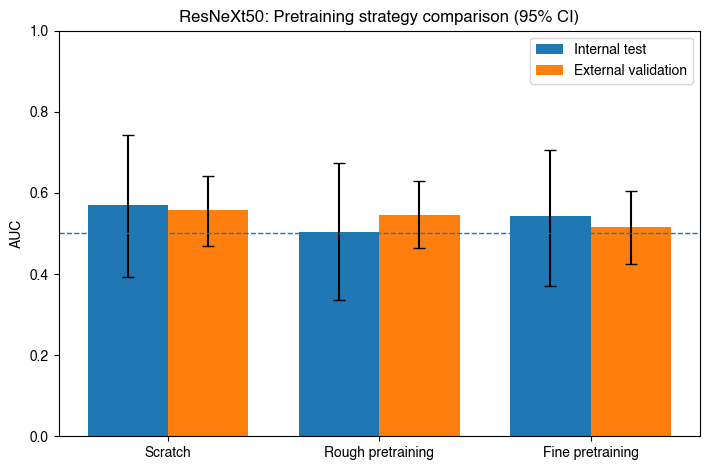

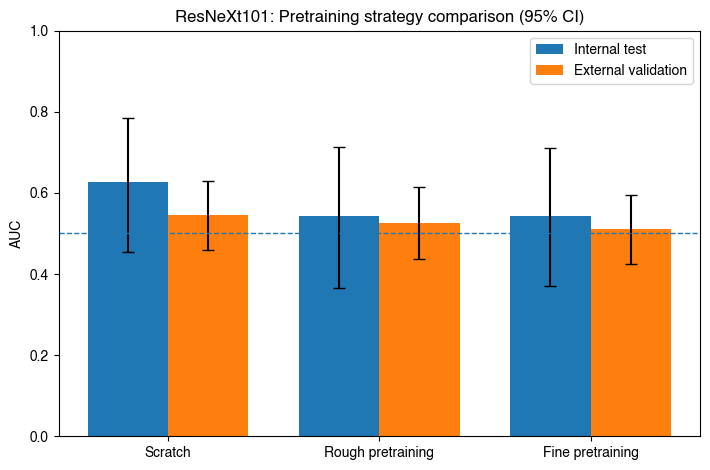

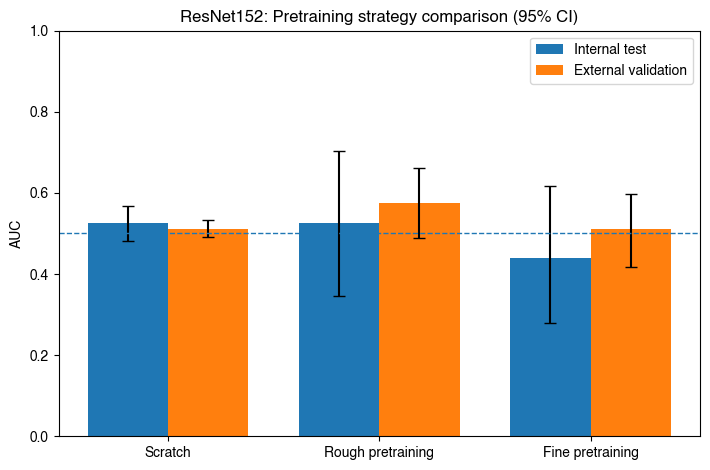

In [27]:
# Optional: rename x-axis labels
strategy_label_map = {
    "scratch": "Scratch",
    "rough": "Rough pretraining",
    "fine": "Fine pretraining",
}

for arch in arch_order:
    plot_pretraining_strategies(
        df_ci,
        arch=arch,
        metric="auc",
        strategy_order=("scratch", "rough", "fine"),
        x_label_map=strategy_label_map
    )